In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def compute_CUSUM(X):
    N = len(X)
    CUSUM = np.zeros(N + 1)
    for k in range(1, N + 1):
        CUSUM[k] = CUSUM[k - 1] + X[k - 1] ** 2
    return CUSUM


def compute_gamma(X, T, m, C):
    gamma = np.zeros(m + 1)
    mean_X = np.mean(X)
    r = X - mean_X  # 잔차 계산
    r_squared = r ** 2
    sigma_squared = np.mean(r_squared)

    for i in range(0, m + 1):
        gamma_i = 0
        for t in range(1, T + 1):
            gamma_i += (r_squared[t - 1] - sigma_squared) * (r_squared[t - i - 1] - sigma_squared)
        gamma[i] = gamma_i / T
    return gamma


def compute_lambda(gamma, m):
    lambda_hat = gamma[0] + 2 * sum((1 - i / (m + 1)) * gamma[i] for i in range(1, m + 1))
    return lambda_hat


def compute_D_prime(CUSUM, T, lambda_hat):
    D_prime = np.zeros(T)
    for k in range(0, T):
        D_prime[k] = (CUSUM[k] - (k / T) * CUSUM[T]) / np.sqrt(lambda_hat)
    return D_prime


def compute_percentile(D_prime, T, percent=99):
    D_prime_abs = np.abs(D_prime) * np.sqrt(T / 2)
    critical_value = np.percentile(D_prime_abs, percent)
    return critical_value

In [3]:
N = 1000
T = N
np.random.seed(0)
X = np.random.normal(0, 1, N)
jump_magnitude = 20
jump_position = N // 2
X[jump_position:] += jump_magnitude

# Neway-West 통계량의 최대시차
m = int(T ** (1 / 4))

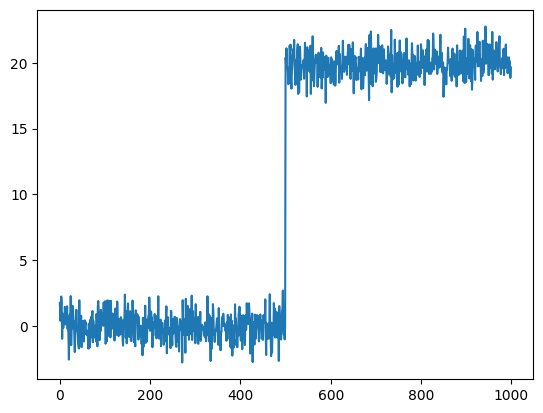

In [4]:
plt.plot(X)

In [5]:
# CUSUM 계산
CUSUM = compute_CUSUM(X)

# gamma 계산
gamma = compute_gamma(X, T, m, CUSUM)

# lambda_hat 계산
lambda_hat = compute_lambda(gamma, m)

# D_prime 계산
D_prime = compute_D_prime(CUSUM, T, lambda_hat)

critical_value = compute_percentile(D_prime, T, percent=99)

In [6]:
ol_lst = list(np.where((np.abs(D_prime) * np.sqrt(T / 2) > critical_value))[0])
print(ol_lst)

[np.int64(495), np.int64(496), np.int64(497), np.int64(498), np.int64(499), np.int64(500), np.int64(501), np.int64(502), np.int64(503), np.int64(504)]


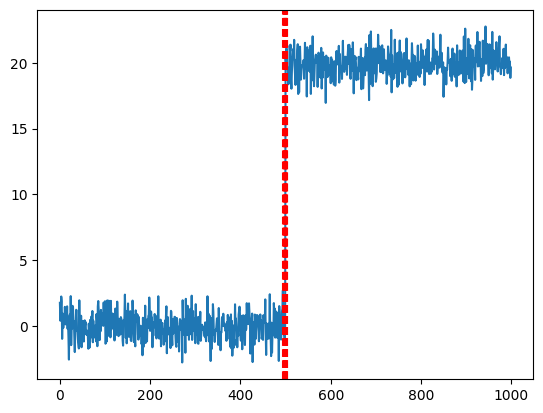

In [7]:
plt.plot(X)
for val in ol_lst:
    plt.axvline(val, color='r', linestyle='--')

# MALLIGYONG

In [9]:
info_df = pd.read_csv('info_df.csv')
info_wo_tle_df = info_df.drop(['tle1', 'tle2'], axis=1).copy()
info_wo_tle_df['time'] = info_wo_tle_df['year'].astype(str) + '-' + info_wo_tle_df['month'].astype(str) + '-' + \
                         info_wo_tle_df['day'].astype(str) + ' ' + info_wo_tle_df['hour'].astype(str) + ':' + \
                         info_wo_tle_df['minute'].astype(str) + ':' + '00'
info_wo_tle_df['time'] = pd.to_datetime(info_wo_tle_df['time'])
info_wo_tle_df.set_index('time', inplace=True)
info_wo_tle_df.drop(['year', 'month', 'day', 'hour', 'minute'], axis=1, inplace=True)
info_wo_tle_df.index.name = None

hour_df = info_wo_tle_df[::60].copy()
hour_df['change'] = (hour_df['change'].diff().fillna(1) >= 1) * 1

In [10]:
perigee_diff = hour_df['perigee'].diff().dropna().values

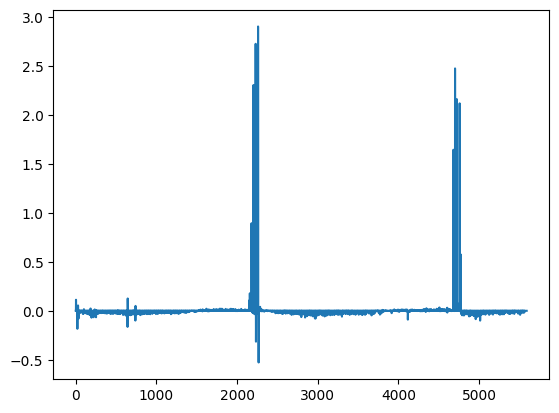

In [11]:
plt.plot(perigee_diff)

In [13]:
window_size = 1000
lambda_lst = []
cv_lst = []
current_lst = []

for i in tqdm(range(window_size, len(perigee_diff), 1)):
    X = perigee_diff[i - window_size:i]
    N = len(X)
    T = N
    m = int(np.sqrt(T))

    # CUSUM 계산
    CUSUM = compute_CUSUM(X)

    # gamma 계산
    gamma = compute_gamma(X, T, m, CUSUM)

    # lambda_hat 계산
    lambda_hat = compute_lambda(gamma, m)
    lambda_lst.append(lambda_hat)
    # D_prime 계산

    D_prime = compute_D_prime(CUSUM, T, lambda_hat)

    critical_value = compute_percentile(D_prime, T)
    cv_lst.append(critical_value)
    current_lst.append(np.abs(D_prime[-1]) * np.sqrt(T / 2))

100%|██████████| 4591/4591 [00:53<00:00, 85.88it/s]


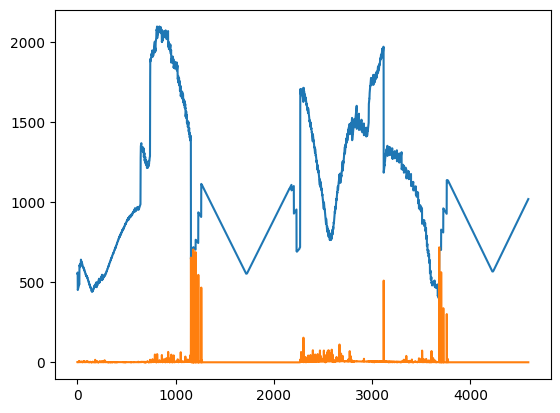

In [17]:
#plt.plot(lambda_lst)
plt.plot(cv_lst)
plt.plot(current_lst)

In [25]:
ol_lst = list(np.where((np.array(current_lst) > np.array(cv_lst)))[0] + window_size)

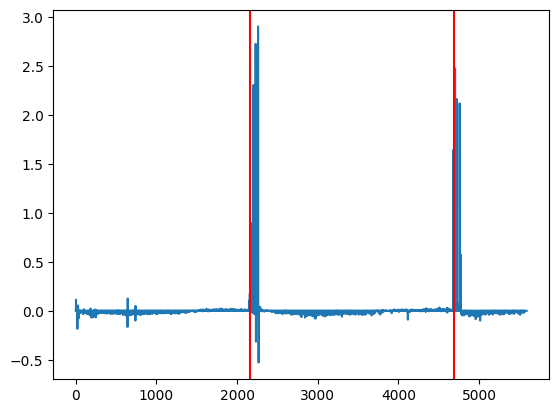

In [27]:
plt.plot(perigee_diff)
for point in ol_lst:
    plt.axvline(point, color='r')

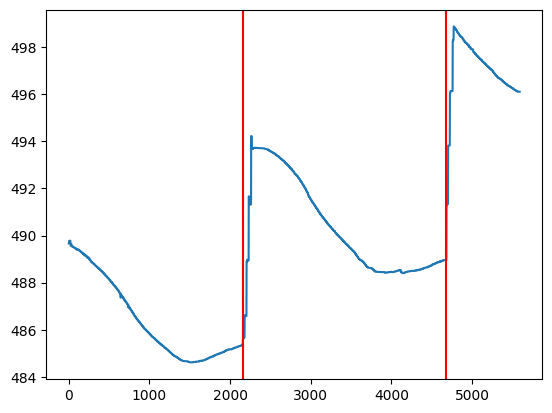

In [28]:
plt.plot(hour_df['perigee'].values)
for point in ol_lst:
    plt.axvline(point, color='r')